# Split Data into Patches

### Based on https://arxiv.org/pdf/1707.06978.pdf

For this component of the project, I made a local copy of __gs://cbis-ddsm by running (gsutil -m cp -r gs://cbsis-ddsm /home/<USER_NAME>/data)__ within my keras instance.  Change user_name

Then you should rename some of the underlying folders to make life easier, and create four folders within data: 
    - malignant
    - benign
    - benign_no_callback
    - no_tumor

In [20]:
%matplotlib inline
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage.transform import rotate
from skimage.util import view_as_windows
from collections import defaultdict

## From the paper

For the first stage of training, we create a large dataset of image patches sampled from the training images. We enforce that the majority of the patches
come from the breast, by first segmenting using Otsu’s method [21]. 

__Before sampling, we resize the original images with different factors for calcification and
mass patches. Instead of resizing to a fixed size, which would cause distortions because the aspect ratio varies over the images in the dataset, or cropping, which
could cause a loss of information, we resize such that the resulting image falls within a particular range. We set the target size to 2750x1500 and 1100x600
pixels, for the calcification and mass scales, respectively. Given an input image, we calculate a range of allowable resize factors as the min and max resize factors
over the two dimensions. That is, given an example of size, say 3000x2000, the range of resize factors for the calcification scale would be [1500/2000 = 0.75 ,
2750/3000 = 0.92], from which we sample uniformly.__ 

For other sources of data augmentation, __we use horizontal flipping, rotation of up to 30◦__
, and an additional rescaling by a factor chosen between 0.75 and 1.25. We then __sample patches of size 256x256__. 

In the first stage of patch classification training, lesion detection
without malignancy classification, we create 800K patches for each lesion category, split equally between positive and negative samples. In the second stage,
we create 900K patches split equally between normal, benign, and malignant.

## Utils

In [23]:
## Steps from https://arxiv.org/pdf/1707.06978.pdf:
## Resize calcifications to between 2750x1500 with random uniform sampling of the factors
## Resize masses to between  1100x600 with random uniform sampling of the factors
## Horizontal flipping 
## Rotation up to 30 degrees
## Use Otsu's segmentationt ot remove all purely black patches

np.random.seed(1234)

PATH_TO_FILES = '/home/jlandesman/data/cbis-ddsm/calc_training_full_mammogram_images/'
PATH_TO_ROI = '/home/jlandesman/data/cbis-ddsm/calc_training_full_roi_images/'
PATH_TO_ROI_CSV_LABELS = '/home/jlandesman/data/cbis-ddsm/calc_case_description_train_set.csv'

CALC_TARGET_RESIZE = np.array([2750,1500])
MASS_TARGET_RESIZE = np.array([1100, 600])
MAX_ROTATE = 30 ## degrees
STEP_SIZE = 50 ## Stride for getting windows

MASK_CUTOFF = 0 ## If a patch has an average mask value of 0 discard it as it is not in the breast
ROI_CUTOFF = 0 ## If an ROI has an average value of zero, label it "no_tumor" 

###################################################################
# Read in Files
###################################################################
def get_im_as_array(file_name, file_type):
    '''
    Read in an image and yield it as a numpy array
    params: 
        file_name: name of the file
        file_type: either 'full' or 'ROI'
    
    '''
    if file_type == 'full':
        path = PATH_TO_FILES
    elif file_type == 'ROI': ## ROI
        path = PATH_TO_ROI
    else: 
        print("Enter file type as either 'full' or 'ROI'")
        pass

    file_path = os.path.join(path,file_name)
    im = Image.open(file_path)
    return np.asarray(im)

###################################################################
# Associate images with labels
###################################################################

def get_labels(path_to_csv):
    '''
    Concatenates various components of the named files to a list and returns the file_name and pathology
    params:
        path_to_csv: path to the CSV with the file list
    returns: 
        a data frame containing the file_name (as an index) and the pathology.  
    '''
    df = pd.read_csv(path_to_csv)
    df['file_name'] = 'Calc-Training_' + df['patient_id'] + '_' + df['side'] + '_' + df['view'] + '_' + df['abn_num'].astype(str) + '_mask.png'
    df = df[['file_name', 'pathology']]
    df.set_index('file_name', inplace=True)
    return df

def get_mask_list():
    '''
    Associate each file with all of its masses and their pathology (benign, malignant, other).
    Return a dictionary of {file_name: (mask, pathology)}
    '''
    mask_list = defaultdict(list)
    roi_files = os.listdir(PATH_TO_ROI)
    df = get_labels(PATH_TO_ROI_CSV_LABELS)

    for file_name in roi_files:
        mask_list[file_name[:-11]].append((file_name, df.loc[file_name]['pathology']))
    
    return mask_list

###################################################################
# Image transformations
###################################################################

def get_resize_max_min(im, tumor_type):
    '''
    Returns the max and min dimensions for resizing per the paper
    params:
        im = image
        tumor_type = either 'CALC' or 'MASS'
    returns: 
        the minimum and the maxiumum dimensions for resizing.  This is the range that is then sampled uniformly.
    '''
    if tumor_type == 'CALC':
        resize_min, resize_max = CALC_TARGET_RESIZE/np.array(im.shape)
        
    elif tumor_type == 'MASS':
        resize_min, resize_max = MASS_TARGET_RESIZE/np.array(im.shape)
    
    else: 
        print('Enter either CALC or MASS')
        pass
    return resize_min, resize_max                                                        

def rotate_image(im, rotation_angle):
    '''
    Rotates the image to a random angle < max_rotate
    '''
    return rotate(im, rotation_angle)

def normalize(im):
    '''
    Normalize to between 0 and 255
    '''
    im_normalized = (255*(im - np.max(im))/-np.ptp(im))    
    return im_normalized

###################################################################
# Get patches
###################################################################

def get_patches(im, step_size = 20, dimensions = [256, 256]):
    '''
    Return sliding windows along the breast, moving STEP_SIZE pixels at a time.
    
    IMPORTANT: np.reshape() does not guarantee a copy isn't made - this leads to memory errors
    
    params:
        step_size: the stride by which the window jumps
        dimemsions: the dimensions of the patch
    '''
    patches = view_as_windows(im,dimensions,step=step_size)
    patches = patches.reshape([-1, 256, 256])
    
    return patches

def get_zipped_patches(mammogram, roi, step_size):
    '''
    Return a zipped generator of the image and the corresponding ROI
    
    Looks at each patch and drops bottom 25% by average value (average of the whole image, black = 0)
    
    '''
    mammogram = get_patches(mammogram, step_size)
    roi = get_patches(roi, step_size)
    
    print('Patches array shape before optimization: ', mammogram.shape)
    
    ## NEW OPTIMIZATION CODE ATTEMPT
    ## Eliminate the bottom 25% percent of the image (presumably all black and some of the breast)
    patch_means = np.mean(mammogram, axis = (1,2))
    percentile_cutoff = np.percentile(patch_means, q = 25)
    
    ## Note mask is GREATER THAN cutoff
    mask = np.where(patch_means > percentile_cutoff)
    
    ## Apply mask
    mammogram = mammogram[mask[0],:,:]
    roi = roi[mask[0],:,:]
    
    print('Patches array shape after optimization: ', mammogram.shape)
    
    return zip(mammogram, roi) 

###################################################################
# Main function
###################################################################

def save_patches(zipped_patches, label, save_file_name):
    '''
    Main save patches file
    '''
    
    ### Basic logging/ error checking
    errors = []
    num_original = 0
    num_rotate = 0
    num_flip = 0
    num_resize = 0
    num_not_breast = 0
    
    
    ## Recall that zipped_patches = zip(original, roi), where each dim is [-1, 256, 256]
    for number, patch in enumerate(zipped_patches):
        
        if patch[0].mean() == MASK_CUTOFF: ## If the mean of the image patch = 0, then its purely black and not helpful
            num_not_breast +=1
            continue ## Return to start of loop

        elif patch[1].mean() > 0: ## If this is in the tumor
            if label == 'MALIGNANT':
                save_path = '/home/jlandesman/data/patches/calcification/malignant'

            elif label == 'BENIGN':
                save_path = '/home/jlandesman/data/patches/calcification/benign'

            else:
                save_path = '/home/jlandesman/data/patches/calcification/benign_no_callback'

        else: ## Not in the tumor
            save_path = '/home/jlandesman/data/patches/calcification/no_tumor'

        file_name = save_file_name + "_" + str(number) + ".png"
        
        try:
            ###############
            # Save Original
            ###############
            im = Image.fromarray(patch[0])

            if im.mode != 'RGB':
                    im = im.convert('RGB')

            im.save(os.path.join(save_path, file_name))
            num_original += 1
            
            ##############
            # Rotate
            ##############
            rotation_angle = np.random.randint(low = 0, high = MAX_ROTATE)
            im = Image.fromarray(rotate_image(patch[0], rotation_angle))

            if im.mode != 'RGB':
                    im = im.convert('RGB')

            file_name = save_file_name + "_" + "ROTATE_" + str(number) + ".png"             
            im.save(os.path.join(save_path, file_name))
            num_rotate += 1
            
            ##############
            # Flip
            ##############
            im = Image.fromarray(np.fliplr(patch[0]))

            if im.mode != 'RGB':
                    im = im.convert('RGB')

            file_name = save_file_name + "_" + "FLIP_" + str(number) + ".png"             
            im.save(os.path.join(save_path, file_name))
            num_flip += 1

            ##############
            # Resize
            ##############
            resize_min, resize_max = get_resize_max_min(mammogram, 'CALC')

            dim_0 = np.random.uniform(low = resize_min, high = resize_max)
            dim_1 = np.random.uniform(low = resize_min, high = resize_max)

            resize_dims = np.round([dim_0*mammogram.shape[0], dim_1*mammogram.shape[1]])

            im = Image.fromarray(resize(patch[0], resize_dims))
            
            if im.mode != 'RGB':
                im = im.convert('RGB')

            file_name = save_file_name + "_" + "RESIZE" + str(number) + ".png"             
            im.save(os.path.join(save_path, file_name))
            num_resize += 1
            
        except:
            errors.append(file_name)
    print ('Original: {}, Rotate: {}, Flip: {}, Resize: {}, Not Breast: {}'.format(num_original, num_rotate, num_flip, num_resize, num_not_breast))
    print (len(errors))

## Pseudocode

for image in list_of_images 

    OPEN Image
        GET_patches
        if PATCH == 0, discard.  else:

    for ROI  in Image:
        OPEN ROI
        filter_patches:
            malignant
            benign
            benign_no_callback
            and no_tumor
            
        save_original
        
        ROTATE Image
        save_patches
        
        FLIP IMAGE (horizontal)
        save_patches
        
        RESIZE IMAGE
        save_patches

## Try with two files below - this code has generated over 70k images from the first file (and takes hours!) Clearly something is not right.   

It makes sense.  There are ~35k potential images in this list, with 4 transformations (flip, rotate, resize and original) = 140k potential images. -- And that is just with one ROI (this code unfortunately repeats saving down each image per ROI, needs to be fixed.)

In [ ]:
## Get dictionary of {mammogram_file_name: (ROI_file, label)}
file_list = get_mask_list()

for mammogram_img in list(file_list.keys())[0:2]:
    print("Image name: {}, Number of ROIS: {} ".format(mammogram_img, len(file_list[mammogram_img])))
    
    ## Get images as np array
    mammogram = get_im_as_array(mammogram_img, 'full')
        
    for roi_num, roi_img in enumerate(file_list[mammogram_img]):
        
        ## Get ROI
        roi = get_im_as_array(roi_img[0], 'ROI')
        
        ## Get label
        label = roi_img[1]
        
        ## Transform into pathces
        zipped_patches = get_zipped_patches(mammogram, roi, step_size = STEP_SIZE)
                
        if roi_num == 0: ## Run through original image
            save_patches(zipped_patches,label, mammogram_img) 

        else: ### Dealing with images that have multiple ROIs - only look at the tumor sections
            print('Starting with ROI: ', roi_img)
            patch_means = np.mean(roi, axis = (1,2))
            mask = np.where(patch_means > 0)
            
            ## filter
            mammogram = mammogram[mask[0],:,:]
            roi = roi[mask[0],:,:]
            
            zipped_patches = zip(mammogram, roi)
            save_patches(zipped_patches,label, mammogram_img)         ## Save down
                    
        ## Memory Management
        del(zipped_patches) 

Image name: Calc-Training_P_00410_RIGHT_CC, Number of ROIS: 1 
Patches array shape before optimization:  (7260, 256, 256)
Patches array shape after optimization:  (5445, 256, 256)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Original: 4576, Rotate: 4576, Flip: 4576, Resize: 4573, Not Breast: 0
872
Image name: Calc-Training_P_00452_LEFT_CC, Number of ROIS: 1 
Patches array shape before optimization:  (5104, 256, 256)
Patches array shape after optimization:  (2893, 256, 256)


# OLD CODE -- IGNORE BELOW

In [ ]:
im = Image.open(os.path.join(PATH_TO_ROI,'Calc-Training_P_00502_LEFT_CC_1_mask.png'))

In [ ]:
im = get_im_as_array('Calc-Training_P_02270_RIGHT_MLO', 'full')
plt.imshow(im)

### Open up each file and its masks

In [ ]:
mammogram = get_im_as_array(list(file_list.keys())[0], 'full')
roi = get_im_as_array(list(file_list.values())[0][0][0], 'ROI')

mammogram = get_patches(mammogram)
roi = get_patches(roi)

## NEW OPTIMIZATION CODE ATTEMPT
## Eliminate the bottom 25% percent of the image (presumably all black and some of the breast)
test = np.mean(mammogram, axis = (1,2))

print(test.shape)


# patch_means = np.mean(np.array([mam[0] for mam in mammogram]), axis = (1,2))
# percentile_cutoff = np.percentile(patch_means, q = 25)

# ## Note mask is GREATER THAN cutoff
# mask = np.where(mean_score > percentile_cutoff)

# ## Apply mask
# mammogram = mammogram[mask[0],:,:]
# roi = roi[mask[0],:,:]


# roi = roi/255 ## Normalize to between 0-1

# label = list(file_list.values())[0][0][1]
# label

### Get the Otsu's Mask Segementation of the image

In [ ]:
mask = get_mask(mammogram)
mask = mask/255 ## Normalize to between 0/1

### Visualization

In [ ]:
fig = plt.figure()
a=fig.add_subplot(1,3,1)
plt.imshow(mammogram)

a=fig.add_subplot(1,3,2)
plt.imshow(roi)

a=fig.add_subplot(1,3,3)
plt.imshow(mask)

### For each image, we want to: 
* Preprocess the image
* Divide into patches
* Check if each patch is largely in the breast. If not, discard it.
* Check if each patch is in the ROI
* Save the image into an appropriate folder either "benign, malignant, benign_without_callback, or no_tumor

The strategy for checking whether each patch is in the breast or in the ROI is to look at a mean value of the ROI and the Otsu masks and determine a threshold for cutting off an image

In [ ]:
def get_zipped_patches():
    return zip(get_patches(mammogram), get_patches(roi), get_patches(mask)) 

mean_roi = np.array([patch[1].mean() for patch in get_zipped_patches()])
mean_mask = np.array([patch[2].mean() for patch in get_zipped_patches()])


fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.hist(mean_roi)
plt.title('Distribution of ROI avg')

a=fig.add_subplot(1,2,2)
plt.hist(mean_mask)
plt.title('Distribution of MASK avg')

### Cutoff threshold

It seems for this sample image that cutting off at zero will eliminate most of the ROI (this is a large ROI) and 12% of the mask.  If this does not work, this is a key threshold to change in the future to avoid a lot of meaningless patches.  These values are stored in __MASK_CUTOFF__ and __ROI_CUTOFF__ above.

In [ ]:
from __future__ import division
percent_roi_not_equal_zero = len(mean_roi[mean_roi > 0])/mean_roi.shape[0]
percent_mask_not_equal_zero = len(mean_mask[mean_mask>0])/mean_mask.shape[0]

print('Percent of ROI != 0 {}'.format(percent_roi_not_equal_zero))
print('Percent of Mask != 0 {}'.format(percent_mask_not_equal_zero))

In [ ]:
print(get_resize_dims(mammogram), get_resize_dims(roi, not_random = False), get_resize_dims(mask, not_random = False))

rotation_angle = np.random.randint(low = 0, high = MAX_ROTATE)

## Old functions previously in utils

In [ ]:
# def get_resize_dims(im, dim_0, dim_1):
#     '''
#     Uniformly choose between resize_min and resize_max dimesnions 
#     Default is the "second resizing" mentioned in the paper above
#     Use random to determine if we want a new randomization or to preserve the last one
#     or to make sure if the masks and images are identical
#     '''
#     if not_random:
#         np.random.seed(1234)
    
#     dim_0 = np.random.uniform(low = resize_min, high = resize_max)
    
#     if not_random:
#         np.random.seed(1234)
    
#     dim_1 = np.random.uniform(low = resize_min, high = resize_max)
#     return np.round([dim_0*im.shape[0], dim_1*im.shape[1]])


# def get_mask(im):
#     '''
#     Return OTSU's threshold mask. For use to make sure that the image patches are within the breast, not the empty space outside 
#     '''
#     ## OTSU's threshold
#     thresh = threshold_otsu(im)
#     binary = im >= thresh
#     return(binary)

#     mask = get_mask(mammogram)
#     mask = mask/255 ## Normalize to between 0/1


In [3]:
df = pd.read_csv(PATH_TO_ROI_CSV_LABELS)

In [4]:
df.head()

,patient_id,breast_density,side,view,abn_num,calc_type,calc_distribution,assessment,pathology,subtlety,od_img_path,od_crop_path,mask_path
0,P_00005,3,RIGHT,CC,1,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
1,P_00005,3,RIGHT,MLO,1,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
2,P_00007,4,LEFT,CC,1,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
3,P_00007,4,LEFT,MLO,1,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
4,P_00008,1,LEFT,CC,1,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp


In [9]:
counts = df.groupby('patient_id')['pathology'].count()

In [10]:
len(counts[counts>1])

578

In [11]:
len(counts)

603

In [13]:
df.shape

(1622, 13)

In [14]:
counts.mean()

2.6898839137645107

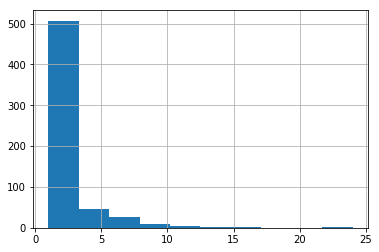

In [15]:
counts.hist()